# Automatic download and processing of OLCI satellite images using SNAP on python
*Author:* Corrado Motta - corradomotta92@gmail.com

This notebook is intended to cover the following steps by making use of python code and libraries:
- Automatically downloading multiple OLCI Sentinel-3 satellite images including chl-a and TSM concentration with a number of configuration items (e.g. time window, clouds coverage, area of interest, type of product, etc.).
- Checking the integrity of downloaded data and plot them.
- Processing the downloaded images (chl and tsm analysis supported by now):
    - Subsetting the images to the area of interest.
    - Masking the unvalid data.
    - Performing temporal aggregation of some kind on a band of interest. Types of aggregation available:
        - Average
        - Average without outliers
        - Min and Max
    - Save the final results (either in .nc or .dim) and show them on the notebook as well.
- Extracting pixel values by given coordinates points and save them on an excel sheet.

Further this notebook is divided into sections and sections into blocks with informative text to facilitate the understanding of each part. More information are contained into the handbook provided as a PDF as part of this internship. As this is a new script run a limited number of times, it can contains bug/errors. Contact me for any error or information you may need.

**NOTE!**
Before running this script, you need to make sure the global environmental variables for OLCI Sentinel-3 data are correctly set. To do that you need to open SNAP toolbox:

- Open SNAP. Click on Tools > Options > S3TBX and check the box shown in figure. More information in the handbook.
- Uncheck the other boxes if you do not need them.

<img src="images/Orthorectified.PNG" width="600"/>

You will also need to create an account at EUMETSAT. More information are stored in the handbook.

## Setting the configuration file
This notebook comes with a configuration file named `OLCI_configuration.ini`. There, it is possible to set all parameters used in this script. You can see four different sections in the file:
1. **account_options** Used to store your account credentials to EUMETSAT.
2. **storage_options** Where you want your data and results to be stored.
3. **download_options** Set of options to download the OLCI imagery.
4. **flag_options** Set of flags to download the OLCI imagery.
5. **sentinel3_request_options** Specific set of options for Sentinel-3 imagery (for example the product type).
6. **aggr_request_options** Set of options to perform the temporal aggregation and the pixel values extraction.

More information are contained under each section and before each parameter directly in the configuration file.
Before run this notebook, make sure to set the configurable parameters as you like, the default configuration is for one of the scenario described in the handbook.

## Automatic download of Sentinel-3 OLCI imagery 
In order to download Sentinel-3 OLCI imagery we need to access EUMETSAT data. The best way to do that is to make use of the existing python resources developed by EUMETSAT itself and provided in their GitLab repository: https://gitlab.eumetsat.int/eumetlab.  Under "cross-cutting tool" a Python-based Sentinel satellite data downloader is already available. The readme file contains all the needed information to run the script properly. 

In this notebook you just need to run the next code blocks. First of all let's import the basic packages needed at this point

In [1]:
# miscellaneous OS interfaces
import os 
from os import listdir
from os.path import isfile, join
import shutil
import warnings
import configparser
import ctypes

# to unzip the files
from zipfile import ZipFile

#constants
MB_OK = 0x0
MB_YESNO = 0x04
ICON_STOP = 0x10
ICON_EXLAIM=0x30

Next, we start to read the configurable parameters we need to perform the download. After, we check that all folders exists.

In [2]:
# read the ini file and store the values into variables
read_config = configparser.ConfigParser()
read_config.read("OLCI_configuration.ini")

data_path = read_config.get("storage_options", "output_root_directory")
result = read_config.get("storage_options", "result_root_directory")
file_manifest = "xfdumanifest.xml"

# get specified bands if any
if(read_config.get("download_options","get_specified_bands") == "True"):
    # read directly into a list
    spec_band = read_config.get("download_options", "specified_bands").split(",")

In [3]:
# check that folders exists or create them.
if not os.path.exists(data_path):
    os.makedirs(data_path)
    
if not os.path.exists(result):
    os.makedirs(result)

# check if the path is empty
if(os.listdir(data_path) and read_config.get("download_options","run_download") == "True"):
    MessageBox = ctypes.windll.user32.MessageBoxA
    chs = MessageBox(None, 'Directory is not empty! please not that the script will remove all not zipped files contained in this directory. Do you want to proceed?', 'Warning', MB_YESNO | ICON_EXLAIM)
    if(chs == 7): raise SystemExit("Directory not empty")

If the previous conditions are satisfied, we are ready to run the downloader script. However if the `run_download` option is set to false, this part will be skipped.

In [4]:
if(read_config.get("download_options","run_download") == "True"):
    %run -i Universal_Sentinel_Downloader.py

In [5]:
# let's check what we have in the folder now
if(len(listdir(data_path)) ==0): raise SystemExit("The directory is empty!")
print('number of items in data path: {0}'.format(len(listdir(data_path))))

number of items in data path: 22


## Data integrity check
Great! We downloaded our images in the predefined folder. The next step is to unzip the files (if needed) and check their integrity. We first define a couple of simple function to help with the checks and the unzip:

In [6]:
# function to unzip file
def unzip_data(filename):
    """ Function to unzip data and remove the zip file.
    
    Parameters:
    filename (string): file name to be unzipped.
    """
    try:
        print('Unzipping file {0}'.format(filename))
        with ZipFile(filename, "r") as zipObj:
            zipObj.extractall(data_path)
            # clear up the zip file
        os.remove(filename)
        print('done!')
    except:
        print("Failed to unzip....")
        
def integrity_check(in_dir, in_ref):
    """ Function to check that a directory contains at least all file names given by a list.
    
    Parameters:
    in_dir (string): path to folder.
    in_ref (string): list of file names to check.
    
    Returns:
    A boolean indicating the result.
    """
    count = 0
    for name in in_dir:
        if name in in_ref:
            count +=1
    if count == len(in_ref):
        return True
    return False

We are ready to performs the checks.

In [7]:
# First we define a list that will contain all valid paths
path_list = []
unvalid_list = []

# If we have new data as entire products, we unzip the
for f in listdir(data_path):
    if(f.endswith(".zip")):
        path_list.append(join(data_path, f))

if(not path_list):
    print("No zip files in the directory.")
else:
    # unzip routine
    map(unzip_data, path_list)

# If we downloaded new data with only specific bands, let's check that the directories contains all the files that are needed and add them to path_list
if(read_config.get("download_options","get_specified_bands") == "True"):
    unvalid_list = []
    for f in listdir(data_path):
        fname = join(data_path,f)
        dirs = listdir(fname)
        if (integrity_check(dirs, spec_band)):
            path_list.append(fname)
        else:
            unvalid_list.append(fname)
            
if(unvalid_list):
    print("{0} product(s) over {1} are invalid:".format(len(unvalid_list), len(listdir(data_path))))
    for number, letter in enumerate(unvalid_list):
        print("-- " + str(number + 1) + ": " + letter)

elif(path_list):
    print("All items are valid!")

No zip files in the directory.
6 product(s) over 22 are invalid:
-- 1: C:\Users\corra\Documents\Koster_internship\4. Code\2. Notebook\Sentinel_downloader\data\S3B_OL_2_WFR____20200806T101535_20200806T101835_20200807T180407_0179_042_065_1980_MAR_O_NT_002.SEN3
-- 2: C:\Users\corra\Documents\Koster_internship\4. Code\2. Notebook\Sentinel_downloader\data\S3B_OL_2_WFR____20200809T103802_20200809T104102_20200810T204936_0179_042_108_1980_MAR_O_NT_002.SEN3
-- 3: C:\Users\corra\Documents\Koster_internship\4. Code\2. Notebook\Sentinel_downloader\data\S3B_OL_2_WFR____20200810T101151_20200810T101451_20200811T183319_0179_042_122_1980_MAR_O_NT_002.SEN3
-- 4: C:\Users\corra\Documents\Koster_internship\4. Code\2. Notebook\Sentinel_downloader\data\S3B_OL_2_WFR____20200824T090816_20200824T091116_20200825T152841_0179_042_321_1980_MAR_O_NT_002.SEN3
-- 5: C:\Users\corra\Documents\Koster_internship\4. Code\2. Notebook\Sentinel_downloader\data\S3B_OL_2_WFR____20200825T102304_20200825T102604_20200826T191429_0

In [8]:
# check path_list
#path_list

## Plotting one of the image
Let's take one of the downloaded product (**default**: the first in the list) and plot it to make sure the area downloaded is the correct one. Here we start to make use of the SNAP functionalities, directly in python. We are going to import one of the band (**default**: the chl-a one) and print its B/N image representation.

In python the snappy package is available and based on SNAP toolbox (which is implemented on JAVA). Check: https://senbox.atlassian.net/wiki/spaces/SNAP/pages/19300362/How+to+use+the+SNAP+API+from+Python. More information can be found in the handbook.
Once installed (unfortunately snappy supports only python 2.7, 3.3 or 3.4 so python version should be set accordingly), you can use the same functions of SNAP here in python. 
Let's start by importing the snappy functions we need.

In [9]:
# import matplotlib and numpy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib.colors import LogNorm

# import math for small math operations
import math

# importing snap functions
import snappy
from snappy import ProductIO, WKTReader
from snappy import jpy
from snappy import GPF
from snappy import HashMap

Let's use snappy to simply import the product and select the band. Then a numpy array will be filled with the band values and plotted to form our image.

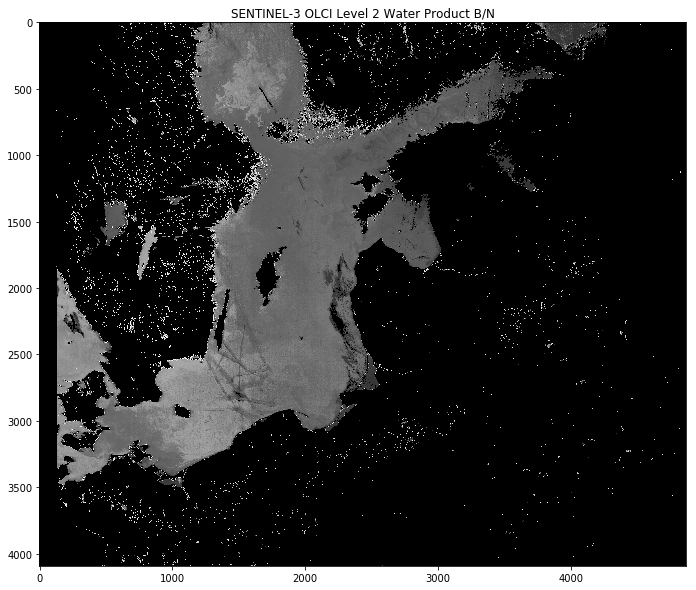

In [10]:
df = ProductIO.readProduct(os.path.join(path_list[0],file_manifest))
band = df.getBand('CHL_NN') # Assign Band to a variable
w = df.getSceneRasterWidth() # Get Band Width
h = df.getSceneRasterHeight() # Get Band Height
# Create an empty array
band_data = np.zeros(w * h, np.float32)
# Populate array with pixel value
band.readPixels(0, 0, w, h, band_data) 
# Reshape
band_data.shape = h, w
# log10
output_array = np.log10(band_data)
# Plot the band  

plt.figure(figsize=(18,10))
plt.imshow(output_array, cmap = plt.cm.binary)
plt.title("{0} B/N".format(df.getDescription()))
plt.show()

## Temporal Aggregation
Now we can use snappy to aggregate the satellite images and create averages. Note that this section works also indipendently from the automatic download. You can manually download Sentinel-3 data and store them in your root directory and change the `run_download` flag to false in the configuration file.

First we read the configuration file again and we save the parameters for the aggregation part.

In [11]:
# read all needed configuration data from the ini file
read_config = configparser.ConfigParser()
read_config.read("OLCI_configuration.ini")

band_name = read_config.get("aggr_request_options", "aggr_band_name").split(",")
aggr_type = read_config.get("aggr_request_options", "aggr_type").split(",")
file_name = read_config.get("aggr_request_options", "aggr_file_name")
file_format = read_config.get("aggr_request_options", "aggr_file_format")
mask_expr = read_config.get("aggr_request_options", "aggr_mask_expression")
super_sampl = read_config.get("aggr_request_options", "aggr_super_sampling")

wkt = read_config.get("aggr_request_options", "aggr_wkt")
resolution = float(read_config.get("aggr_request_options", "aggr_resolution"))

Let's then proceed with the aggregation. We will use the binning function from SNAP. First we define some simple functions. The description of each function is also provided under them:

In [12]:
def compute_num_rows(res_km):
    """ Function to compute the number of rows from a resolution given in km. Taken from SNAP implementation.
   
    Parameters:
    res_km (float): resolution in kilometers.
    
    Returns:
    Resolution in rows.
    """
    RE = 6378.145;
    num_rows =  (int) ((RE * math.pi) / res_km) + 1
    return num_rows if num_rows % 2 == 0 else num_rows + 1


def combine_paths(path):
    """ Function to combine all paths together and separated by a comma, for the SNAP aggregation.
    
    Parameters:
    path (list): A list of paths to be combined.
    
    Returns:
    A string with all paths combined together.
    """
    path_combined = ""
    for f in path:
        if(path_combined):
            path_combined +=","
        path_combined += join(f,file_manifest)
    return path_combined

def band_to_olci_name(name):
    """ Function to convert the input name from the configuration file into the conventional OLCI name needed to perform SNAP operations.
    
    Parameters:
    name (string): the name as specified in the configuration file.
    
    Returns:
    The OLCI name.
    """
    olci_name = ''
    if(name == "chl"): olci_name = 'CHL_NN'
    elif(name == "tsm"): olci_name = 'TSM_NN'
    else: raise SystemExit("band name not assigned or wrong: ", name)
    return olci_name

def combine_file_format(name, extension):
    """ Function to correctly add extensions to filename
    
    Parameters:
    name (string): the name as specified in the configuration file.
    extension (string): the format as as specified in the configuration file.
    
    Returns:
    The name with the extension
    """
    ext = ''
    if(extension == "BEAM-DIMAP"): ext = '.dim'
    elif(extension == "NetCDF4-CF" or extension == "NetCDF4-BEAM"): ext = '.nc'
    else: raise SystemExit("output name or extension not assigned or wrong: ", ext)
    return (name + ext)

And then, based on the configuration file, we set all the parameters for the snappy binning function. Within this function we are able to:
- Select the product to be aggregated (chl or tsm or both).
- Create several different aggregators (e.g. AVG, AVG_OUTLIER, MIN_MAX).
- Mask out clouds, invalid pixels and where the algorithm might have failed.
- Create a subset region where to operate (**default:** Swedish NW coast).
- Set the resolution in km.
- Use super-sampling.
- Save it in different formats (**default:** BEAM-DIMAP. NETCDF4 also available).

The next code block, set all parameters in the snappy function:

In [13]:
# name of the target bands
array_dim = len(aggr_type) * len(band_name)
aggregators = snappy.jpy.array('org.esa.snap.binning.AggregatorConfig',array_dim)

# creates and fill aggregators for all defined bands
count_in = 0 
for aggregator in aggr_type:
    for band in band_name:
        olci_name = band_to_olci_name(band)
        if(aggregator == 'AVG_OUTLIER'):
            aggregator_config_out = snappy.jpy.get_type('org.esa.snap.binning.aggregators.AggregatorAverageOutlierAware$Config')
            agg_constr = aggregator_config_out(olci_name, olci_name + "_OUTLIER", 1.0)
        elif(aggregator == 'AVG'):
            aggregator_config_avg = snappy.jpy.get_type('org.esa.snap.binning.aggregators.AggregatorAverage$Config')
            agg_constr = aggregator_config_avg(olci_name, olci_name, 1.0, False, False)
        elif(aggregator == 'MIN_MAX'):
            aggregator_config_min_max = snappy.jpy.get_type('org.esa.snap.binning.aggregators.AggregatorMinMax$Config')
            agg_constr = aggregator_config_min_max(olci_name, olci_name)
        aggregators[count_in] = agg_constr
        print('aggregators filled at position: ', (count_in))
        count_in += 1

# creating the hashmap to store the parameters
HashMap = snappy.jpy.get_type('java.util.HashMap')
parameters = HashMap()

# set file name and format
dir_out = combine_file_format(join(result,file_name),file_format)
parameters.put('outputFile', dir_out)
parameters.put('outputFormat', file_format)

# apply masks to computation
parameters.put('maskExpr', mask_expr)

# number of rows
num_rows = compute_num_rows(resolution)
parameters.put('numRows', num_rows) 

# super sampling
parameters.put('superSampling', super_sampl) 

# aggregators list
parameters.put('aggregators', aggregators)

# Region to clip the aggregation on
geom = WKTReader().read(wkt)
parameters.put('region', geom)

# Source product path 
path_combined = combine_paths(path_list)
parameters.put('sourceProductPaths', path_combined)

print("\n------------------------------------------------"
      "\nAll parameters set:" 
      "\n---Bands: {0} \n---Aggregator methods: {1} \n---Output file: {2}\n---Output Format: {3} \n---Resolution in rows: {4}"
      "\n---Super-sampling: {5}\n---Mask expression: {6},\n---Region: {7}".format(band_name,aggr_type,dir_out,file_format, num_rows, super_sampl, mask_expr, geom))

('aggregators filled at position: ', 0)

------------------------------------------------
All parameters set:
---Bands: [u'chl'] 
---Aggregator methods: [u'AVG_OUTLIER'] 
---Output file: C:\Users\corra\Documents\Koster_internship\4. Code\2. Notebook\Sentinel_downloader\result\aggregation_mm_product.dim
---Output Format: BEAM-DIMAP 
---Resolution in rows: 66792
---Super-sampling: 1
---Mask expression: not(WQSF_lsb.INVALID or WQSF_lsb.CLOUD or WQSF_lsb.INLAND_WATER or WQSF_lsb.CLOUD_AMBIGUOUS or WQSF_lsb.OCNN_FAIL),
---Region: POLYGON ((8.923302175377243 59.55648108694149, 13.488748662344074 59.11388968719029, 12.480488185001589 56.690625338725155, 8.212366327767503 57.12425256476263, 8.923302175377243 59.55648108694149))


We are ready to create results and store it into our dedicated folder.

**NOTE:** if the file name (`aggr_file_name` in the .ini file ) is the same of the previous run, it will override.

In [14]:
# create results
aggr_product = snappy.GPF.createProduct('Binning', parameters) #to be used with product paths specified in the parameters hashmap

print("results stored in: {0}".format(dir_out))

results stored in: C:\Users\corra\Documents\Koster_internship\4. Code\2. Notebook\Sentinel_downloader\result\aggregation_mm_product.dim


## Open and check the generated product
The product is now saved in the folder and can be open in SNAP toolbox. Let's have a look directly here with python by using other snappy functionalities. First let's check which bands ara available:

In [15]:
print(list(aggr_product.getBandNames()))
lista = aggr_product.getBandNames()

['num_obs', 'num_passes', 'CHL_NN_OUTLIER_mean', 'CHL_NN_OUTLIER_sigma', 'CHL_NN_OUTLIER_counts']


`aggr_product` contains our temporal aggregation. Let's plot one of the band and check how it looks like. To plot it, we are going to use matplotlib and therefore we need to convert our band to a numpy array. To have a proper look into the created products, it is necessary to open it on SNAP.

In [16]:
# select the band to be shown in the map. Default value is the first target band in the generated product
band_to_print = ''
for l in lista:
    if olci_name in l:
        band_to_print = l
        break;
print(band_to_print)

CHL_NN_OUTLIER_mean


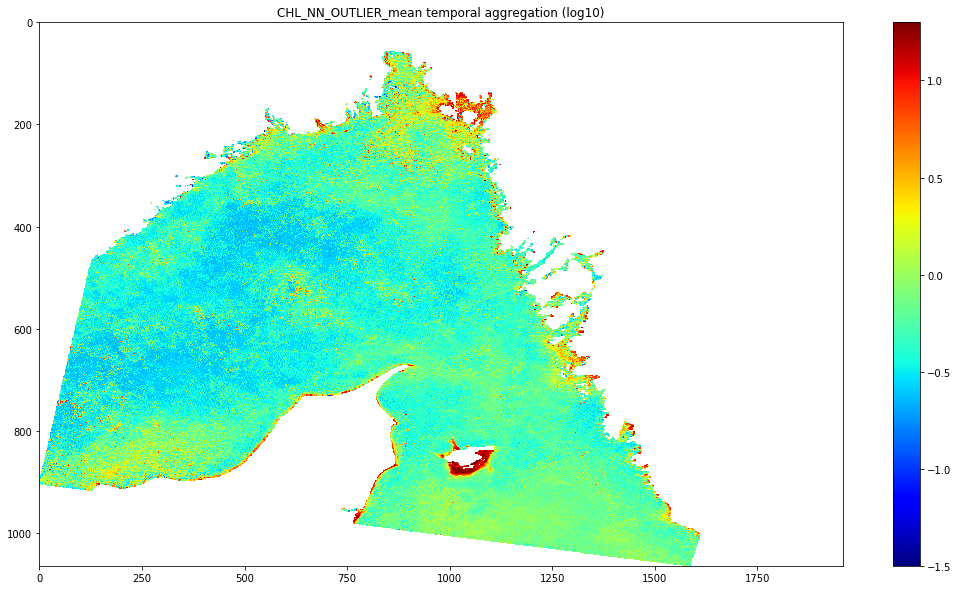

In [17]:
# add your band to print manually
# band_to_print = 'CHL_NN_OUTLIER_mean'
# Assign Band to a variable
band = aggr_product.getBand(band_to_print)

# Get band width and height
w = aggr_product.getSceneRasterWidth() 
h = aggr_product.getSceneRasterHeight()

# Create an empty array
band_data = np.zeros(w * h, np.float32)

# Populate array with pixel value
band.readPixels(0, 0, w, h, band_data) 

# Reshape the numpy array
band_data.shape = h, w

# do log10
output_array = np.log10(band_data)

# Plot the band  
fig, ax = plt.subplots(figsize=(18,10))
pcm = ax.pcolormesh(output_array, vmin=-1.5, vmax=1.3, cmap=plt.cm.jet)
ax.invert_yaxis()
#im = ax.imshow(output_array, cmap = plt.cm.jet)
plt.title(band_to_print + " temporal aggregation (log10)")
fig.colorbar(pcm, ax=ax)

plt.show()

## Extract pixel values from a list of coordinates
In this section we finally extract the values of pixels from the generated products. The list of stations should be a .csv or .txt file with tabular separated values. Three columns are needed at least: _Name_, _Lon_ and _Lat_. The following table is given as an example:

|Name       |Lon          |Lat          |
| ---       | ---         | ---         |
| Station_1 | 10.92391304 | 58.92606899 |
| Station_2 | 10.92660798 | 58.71586418 |
| Station_3 | 11.06674452 | 58.78054258 |
| Station_4 | 10.83767517 | 58.83983112 |

The file path is specified in the configuration file and the result will be stored in the same directory as the main product.


In [18]:
# Reading the ini file
if(read_config.get("aggr_request_options","aggr_pixel_extraction") == "True"):
    coor_path = read_config.get("aggr_request_options", "aggr_extraction_file_path")
    coor_prefix = read_config.get("aggr_request_options", "aggr_extraction_file_prefix")

In [19]:
if(read_config.get("aggr_request_options","aggr_pixel_extraction") == "True"):
    # creating the hashmap to store the parameters
    HashMap = snappy.jpy.get_type('java.util.HashMap')
    parameters = HashMap()

    # set parameters for exporting values
    exportBands = True
    parameters.put('exportBands', exportBands)

    exportTiePoints = False
    parameters.put('exportTiePoints', exportTiePoints)

    exportMasks = False
    parameters.put('exportMasks', exportMasks)
    
    # set parameters for import and export
    parameters.put('coordinatesFile', coor_path)
    parameters.put('outputDir', result)
    parameters.put('outputFilePrefix', coor_prefix)
    
    # run the method
    GPF.createProduct('PixEx', parameters, aggr_product)
    
    print("Pixel values extracted and stored in {0}".format(join(result,coor_prefix)))

Pixel values extracted and stored in C:\Users\corra\Documents\Koster_internship\4. Code\2. Notebook\Sentinel_downloader\result\station_export_ss


To conclude we can use the package Pandas to open the result txt file and print some of the values on the notebook as well.

In [20]:
import pandas as pd

In [21]:
# retrieve the whole name
if(read_config.get("aggr_request_options","aggr_pixel_extraction") == "True"):
    extraction_file = ''
    for f in listdir(result):
        if(f.startswith(coor_prefix) and f.endswith("measurements.txt")):
            extraction_file=join(result,f)
            
    # print the first 5 rows of the file
    if(extraction_file):
        data = pd.read_csv(extraction_file, skiprows=[0,1,2,3,4,5],delimiter="\t")
        print(data.head())
        # save it to csv        
        data.to_csv(join(result,coor_prefix+ ".csv"))

   ProdID  CoordID       Name   Latitude  Longitude  PixelX  PixelY  \
0       0        1  station_1  58.926069  10.923913  1006.5   234.5   
1       0        2  station_2  58.715864  10.926608  1007.5   312.5   
2       0        3  station_3  58.780543  11.066745  1059.5   288.5   
3       0        4  station_4  58.839831  10.837675   974.5   266.5   

  Date(yyyy-MM-dd) Time(HH_mm_ss)  num_obs  num_passes  CHL_NN_OUTLIER_mean  \
0       2020-08-07       23:59:28       10           7             3.344448   
1       2020-08-10       04:51:01       15           8             0.553415   
2       2020-08-09       12:35:09       11           8             0.403680   
3       2020-08-08       21:40:37       13           8             2.450944   

   CHL_NN_OUTLIER_sigma  CHL_NN_OUTLIER_counts  
0              1.090050                    6.0  
1              0.255502                   14.0  
2              0.098330                    9.0  
3              2.840831                    8.0  


Finally we plot the data with bars. Note that the band is selected randomly. You may want to specify your one.

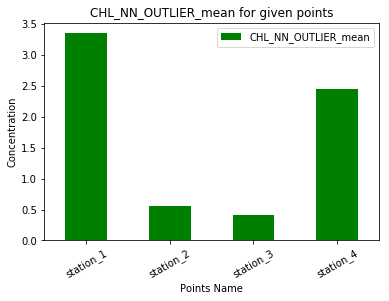

In [22]:
# add your band to print manually
# band_to_print = 'CHL_NN_OUTLIER_mean'

if(read_config.get("aggr_request_options","aggr_pixel_extraction") == "True"):
    data.plot( x='Name', y=band_to_print, kind='bar', color = 'green')  
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.title(band_to_print + " for given points")
    plt.xticks(rotation=30, horizontalalignment="center")
    plt.xlabel("Points Name")
    plt.ylabel("Concentration")